# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

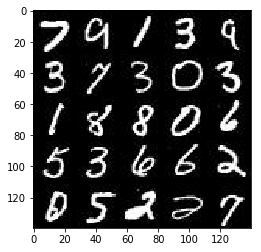

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

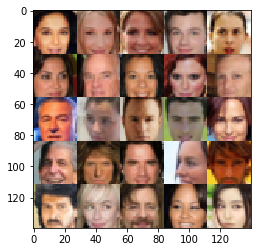

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real') 
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    images_shape = images.get_shape().as_list()
    
    # opening discriminator variable scope
    with tf.variable_scope('discriminator', reuse=reuse):
        # leaky ReLU param
        alpha = 0.2 
        
        # Applying two convolutional layers with batch normalization and activation function leaky ReLU
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha*conv1, conv1)
        # now flowing data has shape batchx14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        # flowing data shape batchx7x7x128
        
        # reshaping data to perform a fully connected layer
        conv2_shape = conv2.get_shape().as_list()
        reshaped = tf.reshape(conv2, [-1, conv2_shape[1]*conv2_shape[2]*conv2_shape[3]]) # making it batchx8192
        
        # dense layer
        discriminator_logits = tf.layers.dense(reshaped, 1, activation=None)
        discriminator_output = tf.sigmoid(discriminator_logits)
      
    

        return discriminator_output, discriminator_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # The generator graph will be structured as follows: fully connected, reshape, batch norm, leaky relu; convolution, 
    # batch norm, leaky relu; convolution, batch norm, leaky relu; 

    
    # everything inside generator variable scope so variables within it have their names starting with generator
    with tf.variable_scope('generator', reuse=not is_train):
        # Leaky ReLU param
        alpha = 0.2
        
        # fully connected layer and reshape
        dense = tf.layers.dense(z, 7*7*512)
        dense = tf.reshape(dense, (-1, 7, 7, 512))
        dense = tf.layers.batch_normalization(dense, training=is_train)
        dense = tf.maximum(alpha*dense, dense)
        
        # first deconvolution
        deconv1 = tf.layers.conv2d_transpose(dense, 256, 5, strides=2, padding='same')
        deconv1 = tf.layers.batch_normalization(deconv1, training=is_train)
        deconv1 = tf.maximum(alpha*deconv1, deconv1)
        
        # Second deconvolution
        deconv2 = tf.layers.conv2d_transpose(deconv1, 128, 5, strides=2, padding='same')
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2 = tf.maximum(alpha*deconv2, deconv2)
          
        # logits. Flowing data already has height and width of 28
        generator_logits = tf.layers.conv2d_transpose(deconv2, out_channel_dim, 5, strides=1, padding='same')
        
        # output
        generator_output = tf.tanh(generator_logits)
   
        return generator_output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # generator output image
    generator_output = generator(input_z, out_channel_dim)
    
    # real discriminator output and logits
    real_discriminator_output, real_discriminator_logits = discriminator(input_real)
    # fake discriminator output and logits
    fake_discriminator_output, fake_discriminator_logits = discriminator(generator_output, reuse=True)
    
    # discriminator real and fake loss
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_discriminator_logits, labels=tf.zeros_like(fake_discriminator_logits)))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_discriminator_logits, labels=tf.ones_like(real_discriminator_logits)))
    discriminator_loss = d_fake_loss + d_real_loss
    
    # generator loss
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_discriminator_logits, labels=tf.ones_like(fake_discriminator_logits)))
    
    
    return discriminator_loss, generator_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
  
    # trainable variables
    trainables = tf.trainable_variables()
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    
    # generator and discriminator optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches. From mnist dataset
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # resetting tf graph
    tf.reset_default_graph()
    
    # placeholders
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # discriminator and generator loss
    discriminator_loss, generator_loss = model_loss(input_real, input_z, data_shape[3])
    
    # training operations
    d_train_op, g_train_op = model_opt(discriminator_loss, generator_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        iteration = 0
        
        for epoch_i in range(1, epoch_count+1):
            for batch_images in get_batches(batch_size):
                iteration+=1
                
                # rescaling batch images
                batch_images = batch_images * 2
                
                # getting batch z noise values
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                # running optimizers
                _ = sess.run(d_train_op, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_train_op, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                
                
                # print statistics and sample
                if iteration%25==0:
                    # getting losses every 100 batches
                    train_loss_d = discriminator_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = generator_loss.eval({input_z: batch_z})
                    # printing stats
                    print('Epoch: {:>2}, discriminator_loss = {:.4f}, generator_loss = {:.4f}'.format(epoch_i, train_loss_d,train_loss_g))


                if iteration%100==0:
                    # Sampling from generator with show_generator_output function
                    show_generator_output(sess, 50, input_z, data_shape[3], data_image_mode)
                    
                


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:  1, discriminator_loss = 0.0117, generator_loss = 5.8797
Epoch:  1, discriminator_loss = 0.4698, generator_loss = 2.4253
Epoch:  1, discriminator_loss = 0.5540, generator_loss = 3.1185
Epoch:  1, discriminator_loss = 0.4654, generator_loss = 1.6914


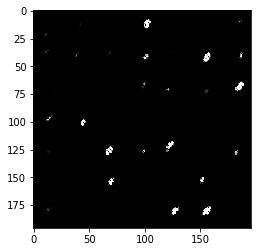

Epoch:  1, discriminator_loss = 1.0995, generator_loss = 2.1174
Epoch:  1, discriminator_loss = 0.7853, generator_loss = 1.0249
Epoch:  1, discriminator_loss = 1.1050, generator_loss = 1.9165
Epoch:  1, discriminator_loss = 0.9976, generator_loss = 1.1879


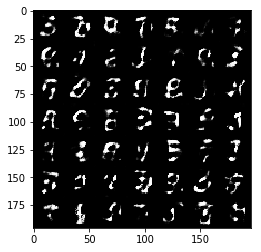

Epoch:  1, discriminator_loss = 1.1697, generator_loss = 1.2444
Epoch:  1, discriminator_loss = 1.6650, generator_loss = 0.6973
Epoch:  1, discriminator_loss = 1.1448, generator_loss = 0.7963
Epoch:  1, discriminator_loss = 1.2500, generator_loss = 1.4839


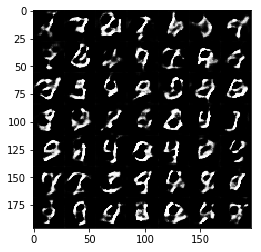

Epoch:  1, discriminator_loss = 1.1237, generator_loss = 0.7934
Epoch:  1, discriminator_loss = 1.0991, generator_loss = 1.5556
Epoch:  1, discriminator_loss = 1.0911, generator_loss = 0.7896
Epoch:  1, discriminator_loss = 1.2887, generator_loss = 0.6480


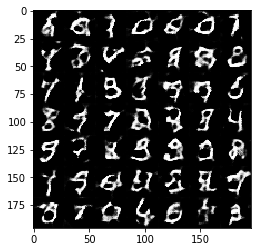

Epoch:  1, discriminator_loss = 1.2092, generator_loss = 1.4139
Epoch:  1, discriminator_loss = 1.4839, generator_loss = 0.3787
Epoch:  2, discriminator_loss = 1.3071, generator_loss = 1.2936
Epoch:  2, discriminator_loss = 1.3708, generator_loss = 1.3241


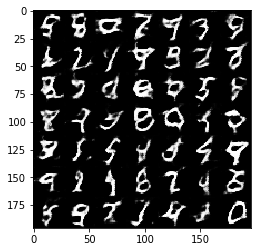

Epoch:  2, discriminator_loss = 1.2316, generator_loss = 1.0329
Epoch:  2, discriminator_loss = 1.1087, generator_loss = 2.0809
Epoch:  2, discriminator_loss = 1.4097, generator_loss = 0.5384
Epoch:  2, discriminator_loss = 1.2214, generator_loss = 0.6560


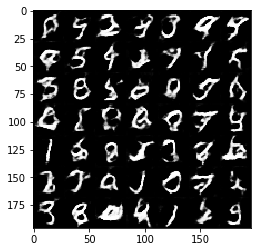

Epoch:  2, discriminator_loss = 1.2003, generator_loss = 0.6768
Epoch:  2, discriminator_loss = 1.6494, generator_loss = 0.3065
Epoch:  2, discriminator_loss = 1.2037, generator_loss = 0.8253
Epoch:  2, discriminator_loss = 1.2790, generator_loss = 0.6902


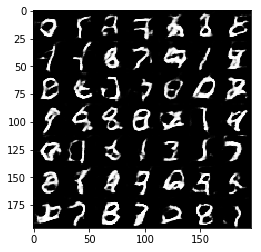

Epoch:  2, discriminator_loss = 2.9166, generator_loss = 0.0884
Epoch:  2, discriminator_loss = 1.4149, generator_loss = 0.5895
Epoch:  2, discriminator_loss = 1.4190, generator_loss = 0.4652
Epoch:  2, discriminator_loss = 1.4069, generator_loss = 0.7481


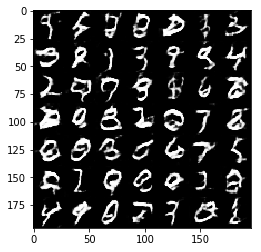

Epoch:  2, discriminator_loss = 1.3066, generator_loss = 0.7835
Epoch:  2, discriminator_loss = 1.4332, generator_loss = 0.4988
Epoch:  2, discriminator_loss = 1.2897, generator_loss = 0.5211
Epoch:  2, discriminator_loss = 1.2775, generator_loss = 0.9980


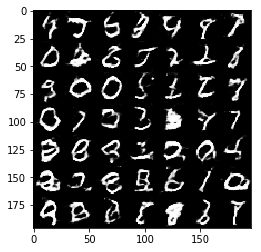

Epoch:  2, discriminator_loss = 1.3285, generator_loss = 0.4898


IndexError: list index out of range

In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:  1, discriminator_loss = 0.4015, generator_loss = 2.0023
Epoch:  1, discriminator_loss = 0.5346, generator_loss = 4.4751
Epoch:  1, discriminator_loss = 0.1969, generator_loss = 2.7416
Epoch:  1, discriminator_loss = 2.1408, generator_loss = 2.4551


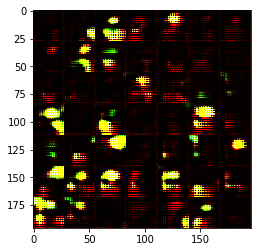

Epoch:  1, discriminator_loss = 2.2790, generator_loss = 8.7423
Epoch:  1, discriminator_loss = 0.1078, generator_loss = 3.0920
Epoch:  1, discriminator_loss = 1.6012, generator_loss = 0.3412
Epoch:  1, discriminator_loss = 0.3262, generator_loss = 2.8570


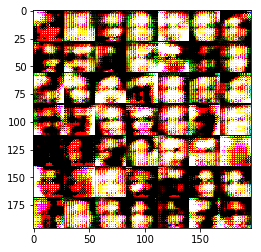

Epoch:  1, discriminator_loss = 0.6311, generator_loss = 1.2179
Epoch:  1, discriminator_loss = 3.1447, generator_loss = 11.8249
Epoch:  1, discriminator_loss = 0.0366, generator_loss = 5.5600
Epoch:  1, discriminator_loss = 0.2984, generator_loss = 1.6482


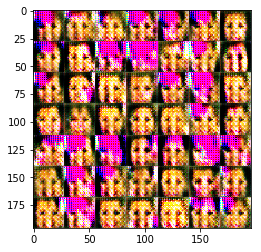

Epoch:  1, discriminator_loss = 2.2056, generator_loss = 3.9571
Epoch:  1, discriminator_loss = 0.6620, generator_loss = 1.6316
Epoch:  1, discriminator_loss = 2.3041, generator_loss = 3.9899
Epoch:  1, discriminator_loss = 1.3251, generator_loss = 2.1175


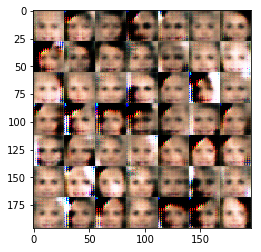

Epoch:  1, discriminator_loss = 1.6425, generator_loss = 0.4015
Epoch:  1, discriminator_loss = 1.1099, generator_loss = 0.8254
Epoch:  1, discriminator_loss = 0.9664, generator_loss = 0.9794
Epoch:  1, discriminator_loss = 1.6082, generator_loss = 0.4245


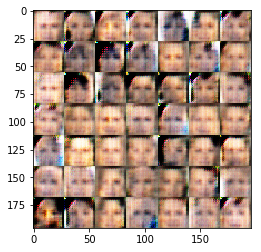

Epoch:  1, discriminator_loss = 1.0386, generator_loss = 1.1554
Epoch:  1, discriminator_loss = 1.8801, generator_loss = 2.0979
Epoch:  1, discriminator_loss = 1.3467, generator_loss = 1.0319
Epoch:  1, discriminator_loss = 1.2774, generator_loss = 1.6057


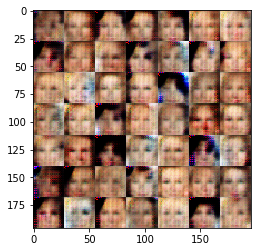

Epoch:  1, discriminator_loss = 0.7290, generator_loss = 1.5131
Epoch:  1, discriminator_loss = 2.0346, generator_loss = 1.6845
Epoch:  1, discriminator_loss = 1.4672, generator_loss = 1.3114
Epoch:  1, discriminator_loss = 1.4099, generator_loss = 0.8770


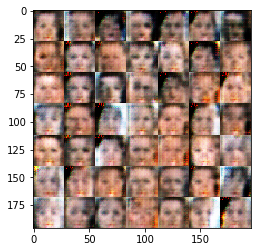

Epoch:  1, discriminator_loss = 1.4219, generator_loss = 1.4566
Epoch:  1, discriminator_loss = 1.3036, generator_loss = 1.0656
Epoch:  1, discriminator_loss = 1.2050, generator_loss = 0.8730
Epoch:  1, discriminator_loss = 1.2731, generator_loss = 1.0131


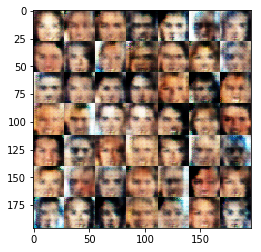

Epoch:  1, discriminator_loss = 1.2954, generator_loss = 0.6819
Epoch:  1, discriminator_loss = 1.3907, generator_loss = 0.4196
Epoch:  1, discriminator_loss = 1.2300, generator_loss = 1.0075
Epoch:  1, discriminator_loss = 1.2962, generator_loss = 0.7571


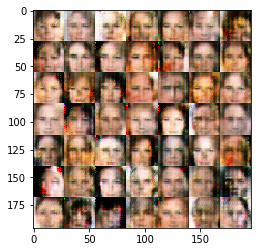

Epoch:  1, discriminator_loss = 1.5522, generator_loss = 0.5727
Epoch:  1, discriminator_loss = 1.3673, generator_loss = 1.0327
Epoch:  1, discriminator_loss = 1.4152, generator_loss = 0.8047
Epoch:  1, discriminator_loss = 1.4708, generator_loss = 0.5628


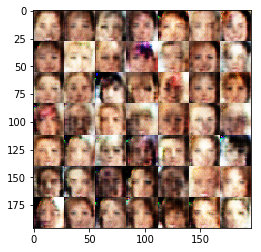

Epoch:  1, discriminator_loss = 1.5989, generator_loss = 0.5623
Epoch:  1, discriminator_loss = 1.4049, generator_loss = 0.4987
Epoch:  1, discriminator_loss = 1.6023, generator_loss = 0.4515
Epoch:  1, discriminator_loss = 1.2665, generator_loss = 1.3549


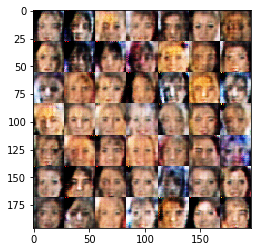

Epoch:  1, discriminator_loss = 1.3329, generator_loss = 1.6567
Epoch:  1, discriminator_loss = 1.3345, generator_loss = 0.8536
Epoch:  1, discriminator_loss = 1.3231, generator_loss = 0.7298
Epoch:  1, discriminator_loss = 1.6051, generator_loss = 0.4103


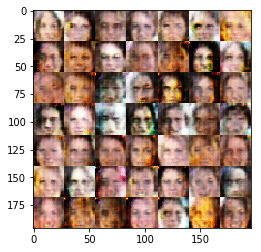

Epoch:  1, discriminator_loss = 1.2222, generator_loss = 0.7017
Epoch:  1, discriminator_loss = 1.5609, generator_loss = 0.6278
Epoch:  1, discriminator_loss = 1.4547, generator_loss = 0.5029
Epoch:  1, discriminator_loss = 1.3799, generator_loss = 0.5948


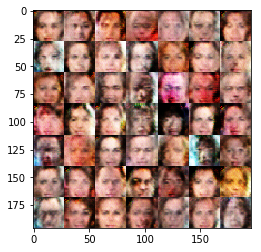

Epoch:  1, discriminator_loss = 1.5385, generator_loss = 0.7057
Epoch:  1, discriminator_loss = 1.1896, generator_loss = 0.7183
Epoch:  1, discriminator_loss = 1.3966, generator_loss = 0.9577
Epoch:  1, discriminator_loss = 1.4885, generator_loss = 0.6826


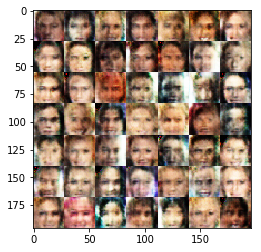

Epoch:  1, discriminator_loss = 1.3738, generator_loss = 0.6981
Epoch:  1, discriminator_loss = 1.4371, generator_loss = 0.9708
Epoch:  1, discriminator_loss = 1.3824, generator_loss = 0.6791
Epoch:  1, discriminator_loss = 1.5602, generator_loss = 1.0733


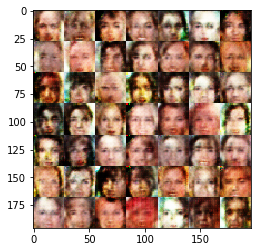

Epoch:  1, discriminator_loss = 1.4825, generator_loss = 0.6170
Epoch:  1, discriminator_loss = 1.3253, generator_loss = 1.1890
Epoch:  1, discriminator_loss = 1.3115, generator_loss = 0.8817


IndexError: list index out of range

In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.